beer/ABV             0
beer/beerId          0
beer/brewerId        0
beer/name            0
beer/style           0
review/appearance    0
review/aroma         0
review/overall       0
review/palate        0
review/taste         0
review/text          0
review/timeUnix      0
user/ageInSeconds    0
user/gender          0
user/profileName     5
dtype: int64
           beer/ABV   beer/beerId  beer/brewerId  review/appearance  \
count  37500.000000  37500.000000   37500.000000       37500.000000   
mean       7.403725  21861.152027    3036.595120           3.900053   
std        2.318145  18923.130832    5123.084675           0.588778   
min        0.100000    175.000000       1.000000           0.000000   
25%        5.400000   5441.000000     395.000000           3.500000   
50%        6.900000  17538.000000    1199.000000           4.000000   
75%        9.400000  34146.000000    1315.000000           4.500000   
max       57.700000  77207.000000   27797.000000           5.000000   

  

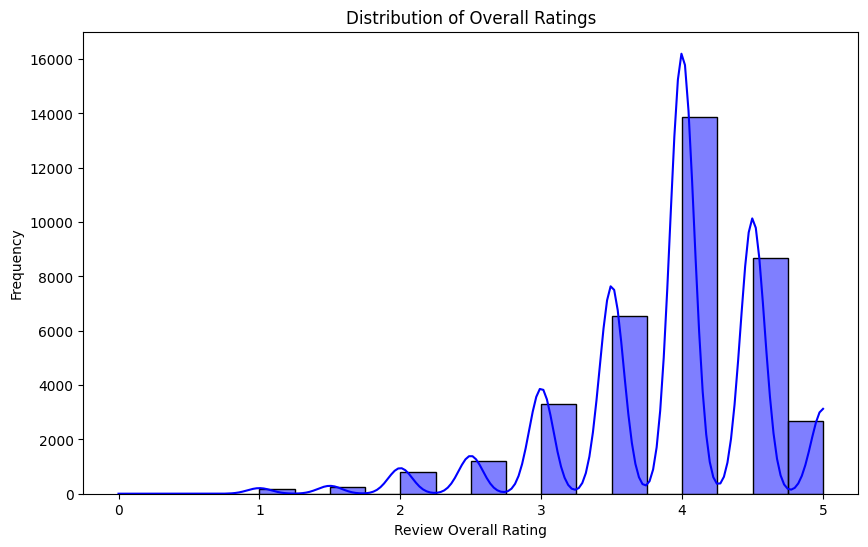

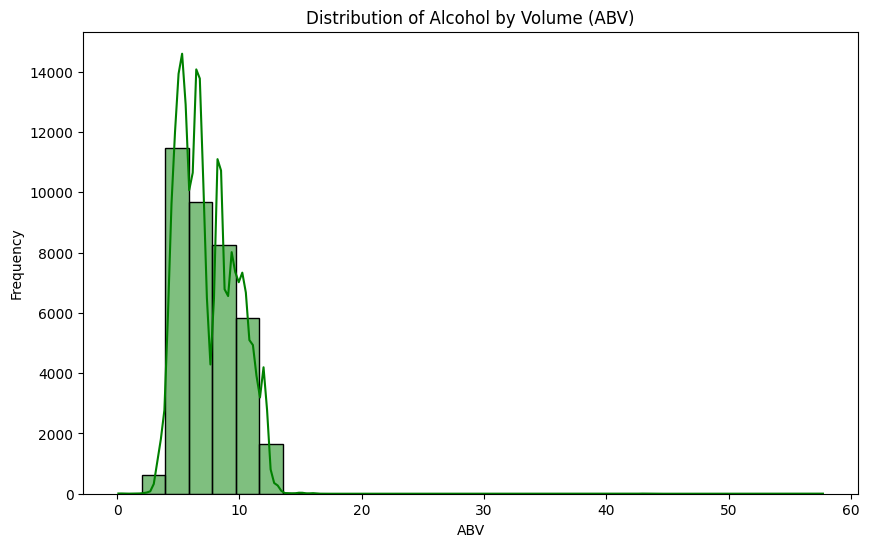

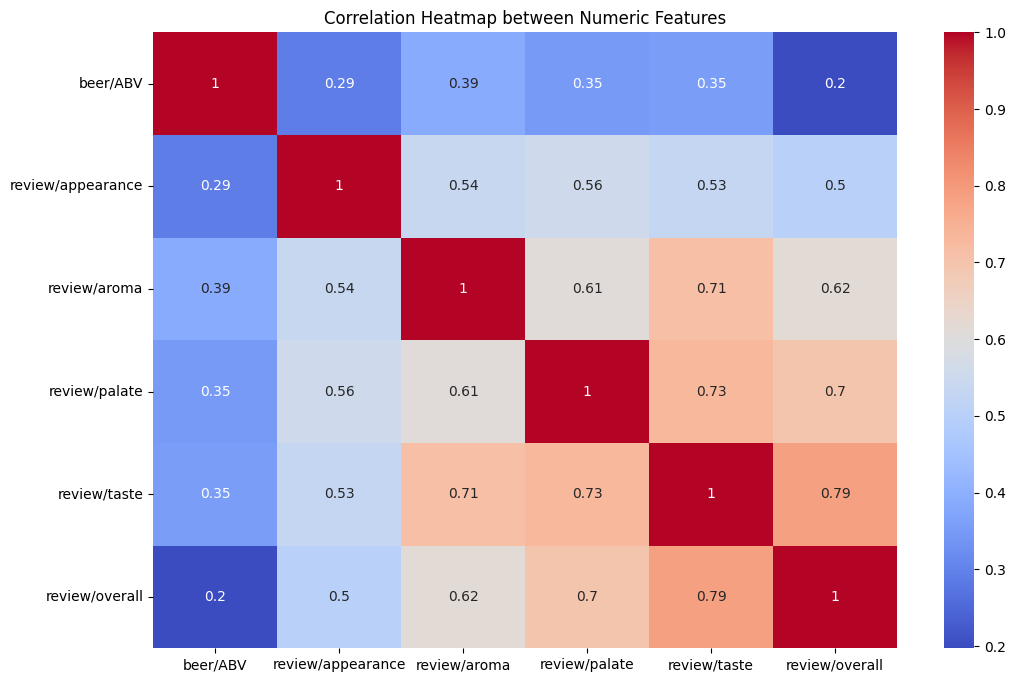

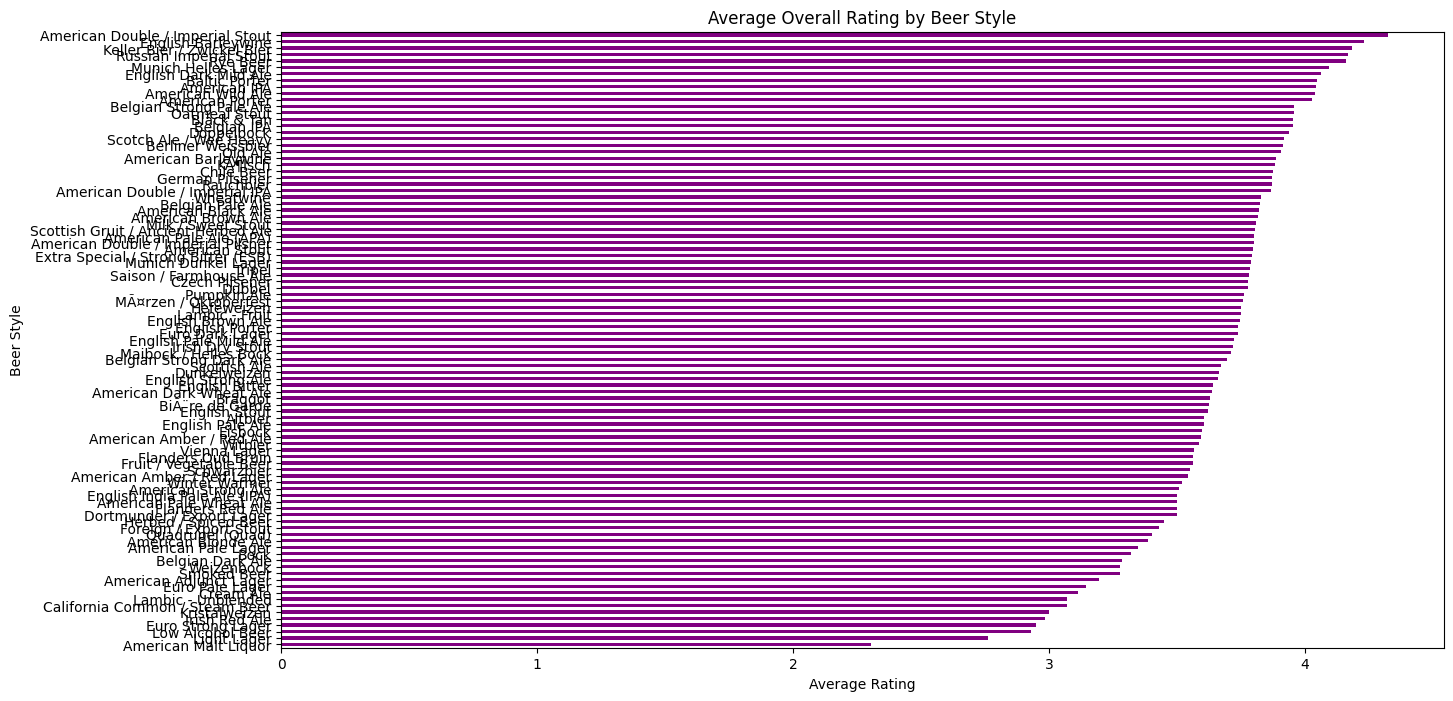

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv('train.csv')

# Drop columns that are not useful for prediction
data = data.drop(columns=['index', 'review/timeStruct', 'user/birthdayRaw', 'user/birthdayUnix'])

# Fill missing review/text with empty strings
data['review/text'] = data['review/text'].fillna('')

# Fill missing user/gender and user/ageInSeconds values
data['user/gender'] = data['user/gender'].fillna('Unknown')
data['user/ageInSeconds'] = data['user/ageInSeconds'].fillna(data['user/ageInSeconds'].median())

# Check for missing values
print(data.isnull().sum())

# Summary of the numerical columns
print(data.describe())

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['review/overall'], bins=20, kde=True, color='blue')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Review Overall Rating')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of ABV (alcohol by volume)
plt.figure(figsize=(10, 6))
sns.histplot(data['beer/ABV'], bins=30, kde=True, color='green')
plt.title('Distribution of Alcohol by Volume (ABV)')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.show()

# Visualize the correlations between numeric features
plt.figure(figsize=(12, 8))
corr = data[['beer/ABV', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap between Numeric Features')
plt.show()

# Plot the average rating by beer style
plt.figure(figsize=(15, 8))
avg_rating_by_style = data.groupby('beer/style')['review/overall'].mean().sort_values()
avg_rating_by_style.plot(kind='barh', color='purple')
plt.title('Average Overall Rating by Beer Style')
plt.xlabel('Average Rating')
plt.ylabel('Beer Style')
plt.show()


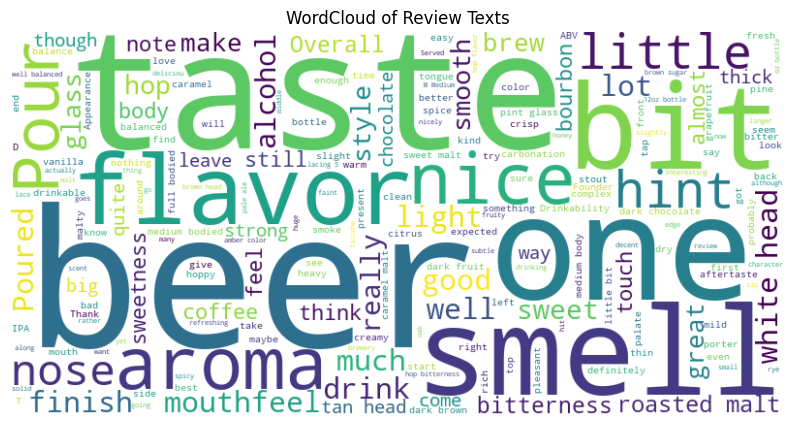

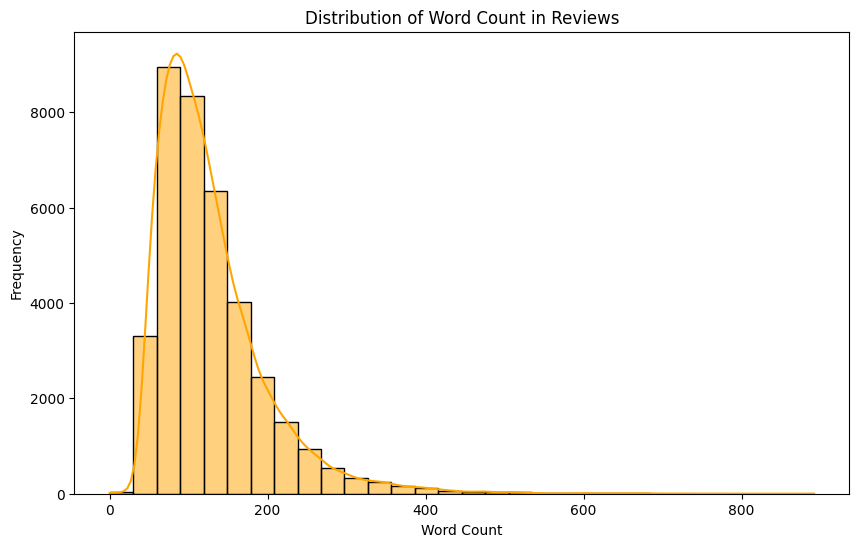

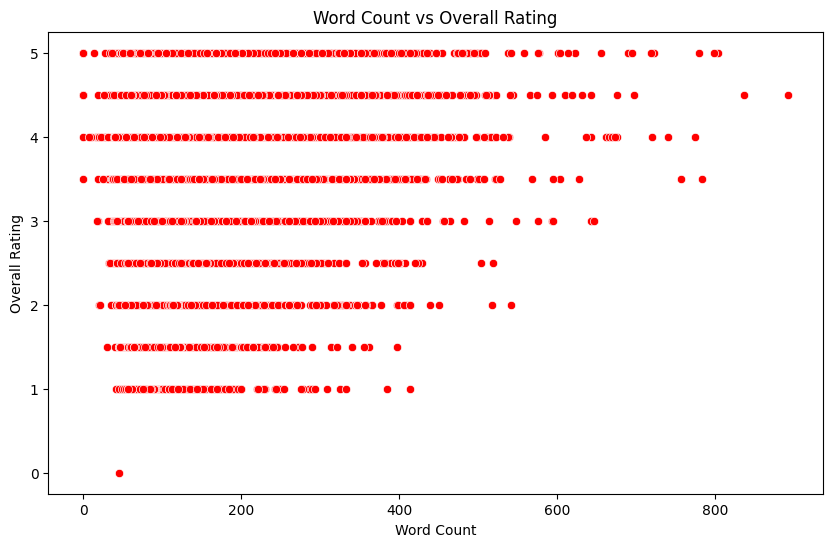

In [2]:
from wordcloud import WordCloud

# Create a WordCloud for review texts
text = " ".join(review for review in data['review/text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud of Review Texts')
plt.show()

# Count the number of unique words in each review
data['word_count'] = data['review/text'].apply(lambda x: len(x.split()))
data['char_count'] = data['review/text'].apply(lambda x: len(x))

# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='orange')
plt.title('Distribution of Word Count in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Relationship between word count and review rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='review/overall', data=data, color='red')
plt.title('Word Count vs Overall Rating')
plt.xlabel('Word Count')
plt.ylabel('Overall Rating')
plt.show()


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Extract features from the 'review/text' column using Tfidf
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_features = tfidf.fit_transform(data['review/text']).toarray()

# Combine numerical features
numeric_features = ['beer/ABV', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'user/ageInSeconds']

# Scale numerical features
scaler = StandardScaler()
scaled_numeric_features = scaler.fit_transform(data[numeric_features])

# Combine tfidf features and numeric features into a single matrix
import numpy as np
X = np.hstack((scaled_numeric_features, tfidf_features))
y = data['review/overall']


RandomForest MSE: 0.15975692, R^2: 0.6752364099727781
Ridge Regression MSE: 0.15594179064462485, R^2: 0.6829920371210098


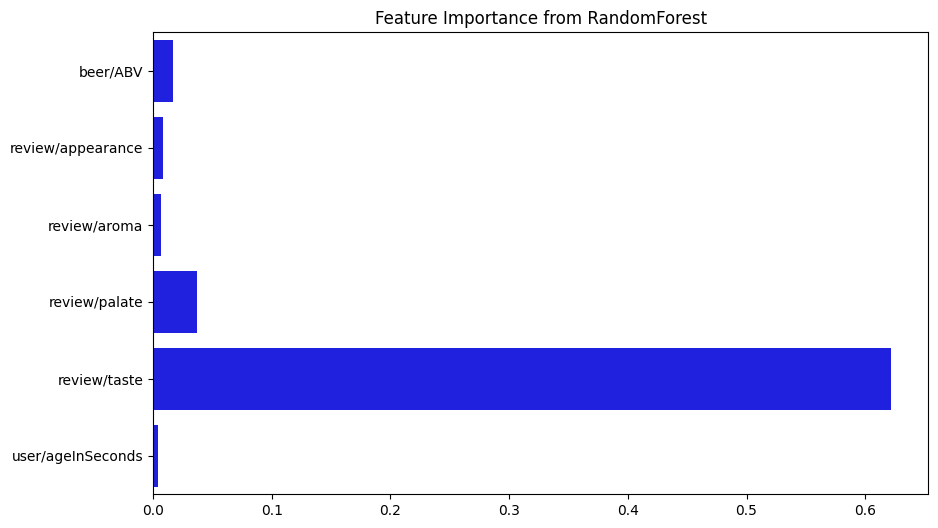

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Ridge Regression Model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RandomForest MSE: {mse_rf}, R^2: {r2_rf}")

# Evaluate Ridge Regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression MSE: {mse_ridge}, R^2: {r2_ridge}")

# Feature Importance from Random Forest
plt.figure(figsize=(10, 6))
feature_importances = rf.feature_importances_[:len(numeric_features)]
sns.barplot(x=feature_importances, y=numeric_features, color='blue')
plt.title('Feature Importance from RandomForest')
plt.show()


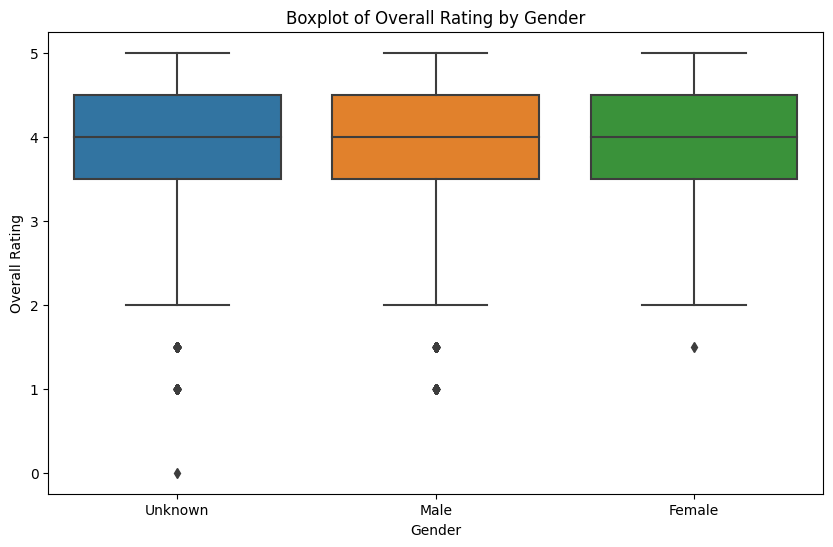

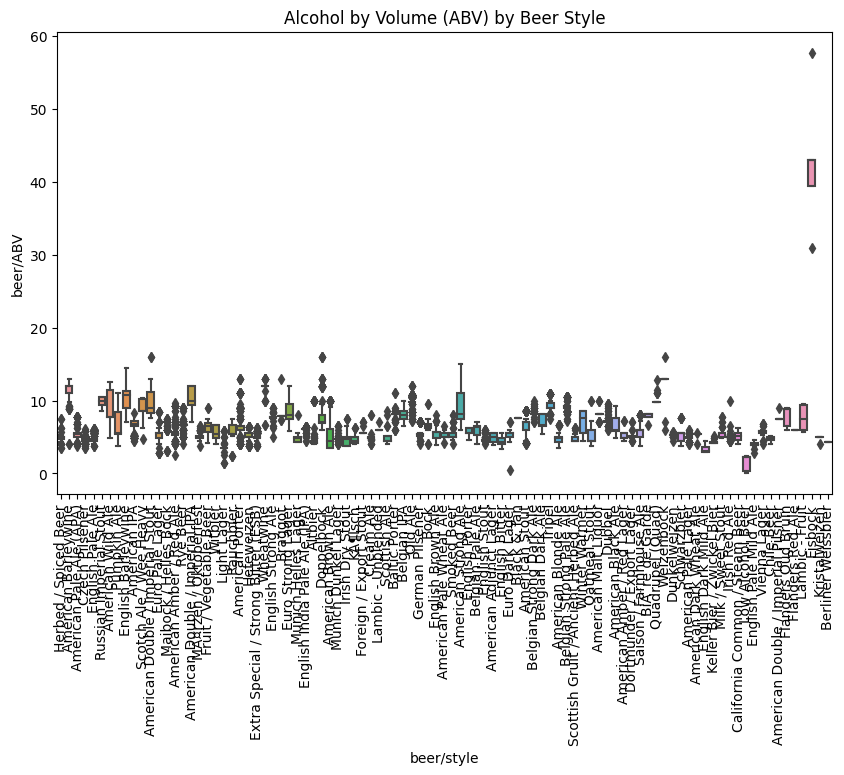

In [5]:
# Distribution of ratings by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='user/gender', y='review/overall', data=data)
plt.title('Boxplot of Overall Rating by Gender')
plt.xlabel('Gender')
plt.ylabel('Overall Rating')
plt.show()

# Analyzing how ABV varies by beer style
plt.figure(figsize=(10, 6))
sns.boxplot(x='beer/style', y='beer/ABV', data=data)
plt.xticks(rotation=90)
plt.title('Alcohol by Volume (ABV) by Beer Style')
plt.show()


1. How can you use "beer/name", "beer/style" and "review/text" as features to predict the overall rating of the beer?
These three columns represent valuable information that can be processed and used as features in a machine learning model:

"beer/name": This column contains the name of the beer, which might capture the brand or specific beer series. Since names themselves don’t directly hold numeric values, you can use text-based techniques:

Categorical encoding: Convert "beer/name" into a categorical feature by using techniques like Label Encoding or One-Hot Encoding to represent beer names as numbers.
String Processing: For names with rich textual information (e.g., names containing keywords such as "Ale," "IPA," or "Stout"), you could extract important words and use them as features. You could tokenize or stem beer names for feature extraction.
"beer/style": This column tells you the type of beer, which likely has a significant impact on how users rate it. Different beer styles (e.g., IPA, Stout, Lager) can have varying ABV, flavors, and characteristics.

One-Hot Encoding or Label Encoding: Use these methods to convert "beer/style" into a set of numeric features that the model can understand.
Frequency encoding: You could also encode "beer/style" based on the frequency with which certain styles appear in the dataset, which might indicate their popularity.
"review/text": This is the most important feature, as it contains the user’s subjective review. You can extract meaningful patterns from the review text using the following methods:

TF-IDF (Term Frequency-Inverse Document Frequency): This can help in determining which words are important across different reviews and create numeric features based on word importance.
Word Embeddings (Word2Vec or GloVe): Represent the review text as dense vectors that capture semantic meaning. This is especially useful if the reviews contain rich descriptions.
Sentiment Analysis: You can apply sentiment analysis to extract the sentiment (positive, negative, neutral) from the reviews, which can strongly correlate with the overall rating.
N-grams: Use word sequences (unigrams, bigrams, or trigrams) to capture key phrases (e.g., "great taste," "too bitter") that can provide more nuanced insight into the review content.
2. Are there any words that strongly predict the overall rating of the beer?
Yes, certain words or phrases in the reviews can strongly correlate with the beer’s overall rating. Here's how you can identify such words:

TF-IDF with Feature Importance: After creating TF-IDF features from the review text, you can analyze the feature importance from models like Random Forest or Gradient Boosting to see which words have the most predictive power.

For example, words like "excellent," "amazing," or "smooth" may correlate with higher ratings, while "disappointing," "too bitter," or "bland" may predict lower ratings.
Sentiment Analysis: Using a sentiment analysis tool (such as VADER or TextBlob), you can quantify the sentiment of the review text. Positive words like "amazing," "smooth," or "flavorful" would likely predict higher ratings, while negative words like "disappointing" or "bland" would predict lower ratings.

N-grams and Word Embeddings: Using N-grams or word embeddings like Word2Vec, you can capture more contextual patterns. For example, phrases like "great aroma" or "too much bitterness" may indicate the overall sentiment toward the beer and be strong predictors of the final rating.

3. How can you use other columns in train.csv to derive robust and effective features from them, which can help to predict the overall rating of the beer?
The dataset includes several other columns that can be used to derive meaningful features:

"beer/ABV": The alcohol by volume (ABV) percentage is likely to have an influence on the beer rating. You can use this as a numeric feature, and possibly bucket it into different ranges (e.g., low ABV, moderate ABV, high ABV) to capture different customer preferences.

"review/appearance", "review/aroma", "review/palate", "review/taste": These columns provide detailed ratings on different aspects of the beer and are highly predictive of the overall rating.

You can use these as-is, or create interaction terms to capture how these features combine to influence the overall rating.
You could also calculate derived metrics such as mean or variance across these attributes for a particular beer or beer style.
"review/timeUnix": This represents the timestamp of the review. You can extract temporal features from this, such as:

Time of Year: Reviews might be seasonally biased (e.g., certain beer types are more popular in winter or summer).
Review Recency: Older reviews might be biased differently compared to more recent reviews. You can create a feature based on how recent a review is (e.g., the number of days since the review was posted).
"user/gender": Although sparsely populated, gender may have some influence on the beer rating. You could treat this as a categorical feature and examine gender-specific preferences.

"user/ageInSeconds": User age (converted from seconds to years) could help segment users into different demographic groups. You can derive features based on age buckets (e.g., young, middle-aged, senior) to understand how different age groups rate beer.

"beer/brewerId" and "beer/beerId": These columns represent the brewery and beer IDs, which could capture the reputation or quality associated with certain brewers or beers. You can:

Use frequency encoding to capture how often a beer or brewery appears in the dataset.
Calculate the average rating per brewery and use it as a feature to understand whether certain brewers consistently produce higher-rated beers.
Summary:
Text features: Use TF-IDF, sentiment analysis, and word embeddings from review/text.
Categorical features like beer/name and beer/style can be encoded using label encoding or one-hot encoding.
Numerical features like ABV, individual review attributes (appearance, aroma, etc.), and user information should be leveraged, possibly along with interaction terms and derived features.
Temporal and demographic features can be engineered from review times and user age, gender, etc., to capture subtle biases or patterns.